In [1]:
from argparse import ArgumentParser
import skimage.io as io
import numpy as np
import random
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import scipy.ndimage
import glob

import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from biCLR import biCLR
from dataset import DFCdataset

In [185]:
input1_dir = '../data/val/rgb_train'
input2_dir = '../data/val/pc_train'
res = 100 
patch_dim = 32
mode = 'vxl'
wgtid = '3307'

In [215]:
input1_dir = '../data/val/rgb'
input2_dir = '../data/val/dsm'
res = 100 
patch_dim = 64
mode = 'dsm'
wgtid = '2864'

In [216]:
ip1 = glob.glob(input1_dir + '/*')
ip2 = glob.glob(input2_dir + '/*')

In [ ]:
for r, (file1, file2) in enumerate(zip(ip1,ip2)):
    gbimg = io.imread(file1)
    gbimg = scipy.ndimage.zoom(gbimg, (5 / res, 5 / res, 1), order=3)

    mean = np.mean(gbimg, axis=(0, 1), keepdims=True)
    std = np.std(gbimg, axis=(0, 1), keepdims=True)
    gbimg = (gbimg - mean) / std

    dm = DFCdataset(file1, file2, mode, res, None, patch_dim)
    datasize = len(dm)

    wgt = './lightning_logs/version_{}/checkpoints/last.ckpt'.format(wgtid)
    biclr = biCLR.load_from_checkpoint(wgt, strict=False, res=res, mode=mode)
    biclr.eval()

    dataloader = DataLoader(dm, batch_size=datasize, shuffle=False, num_workers=0)
    input1, input2 = next(iter(dataloader))
    pres1, pres2 = biclr(input1, input2)
    feature_gl, feature_lcl = biclr.projection(pres1), biclr.projection(pres2)
    glFeature, lclFeature = F.normalize(feature_gl, dim=1), F.normalize(feature_lcl, dim=1)

    similarity_matrix = torch.mm(lclFeature, glFeature.T)


In [ ]:
img = io.imread(file1)
img = scipy.ndimage.zoom(img, (5 / res, 5 / res, 1), order=3)

In [ ]:
gbimg = img.copy()

idx = random.randint(0,datasize-1)

sim = similarity_matrix[idx, :].detach().cpu()

wl = np.floor(gbimg.shape[0]/patch_dim).astype(int)
wh = np.floor(gbimg.shape[1]/patch_dim).astype(int)
x,y = np.unravel_index(idx, (wl, wh))

gbimg[x*patch_dim: (x+1)*patch_dim, y*patch_dim:(y+1)*patch_dim,0] = 255
gbimg[x*patch_dim: (x+1)*patch_dim, y*patch_dim:(y+1)*patch_dim,1] = 0
gbimg[x*patch_dim: (x+1)*patch_dim, y*patch_dim:(y+1)*patch_dim,2] = 0 

fig = plt.figure(figsize=(12,6), dpi= 100)
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

print('index:{}\npredict:{}'.format(idx,np.argmax(sim)))
ax1.imshow(gbimg)
pos = ax2.imshow(sim.reshape(wl,wh))
fig.colorbar(pos, ax=ax2)



In [ ]:
figure1 = plt.figure(figsize=(25, 25))
gs0 = gridspec.GridSpec(1, 1)
gs00 = gridspec.GridSpecFromSubplotSpec(9, 9, subplot_spec=gs0[0])
for i in range(9):
    for j in range(9):
        sim = similarity_matrix[i*9+j, :].detach().cpu()
        ax00 = figure1.add_subplot(gs00[i, j])
        ax00.imshow(sim.reshape(wl,wh))
        ax00.set_xticklabels([])
        ax00.set_yticklabels([])
        ax00.set_aspect('equal')


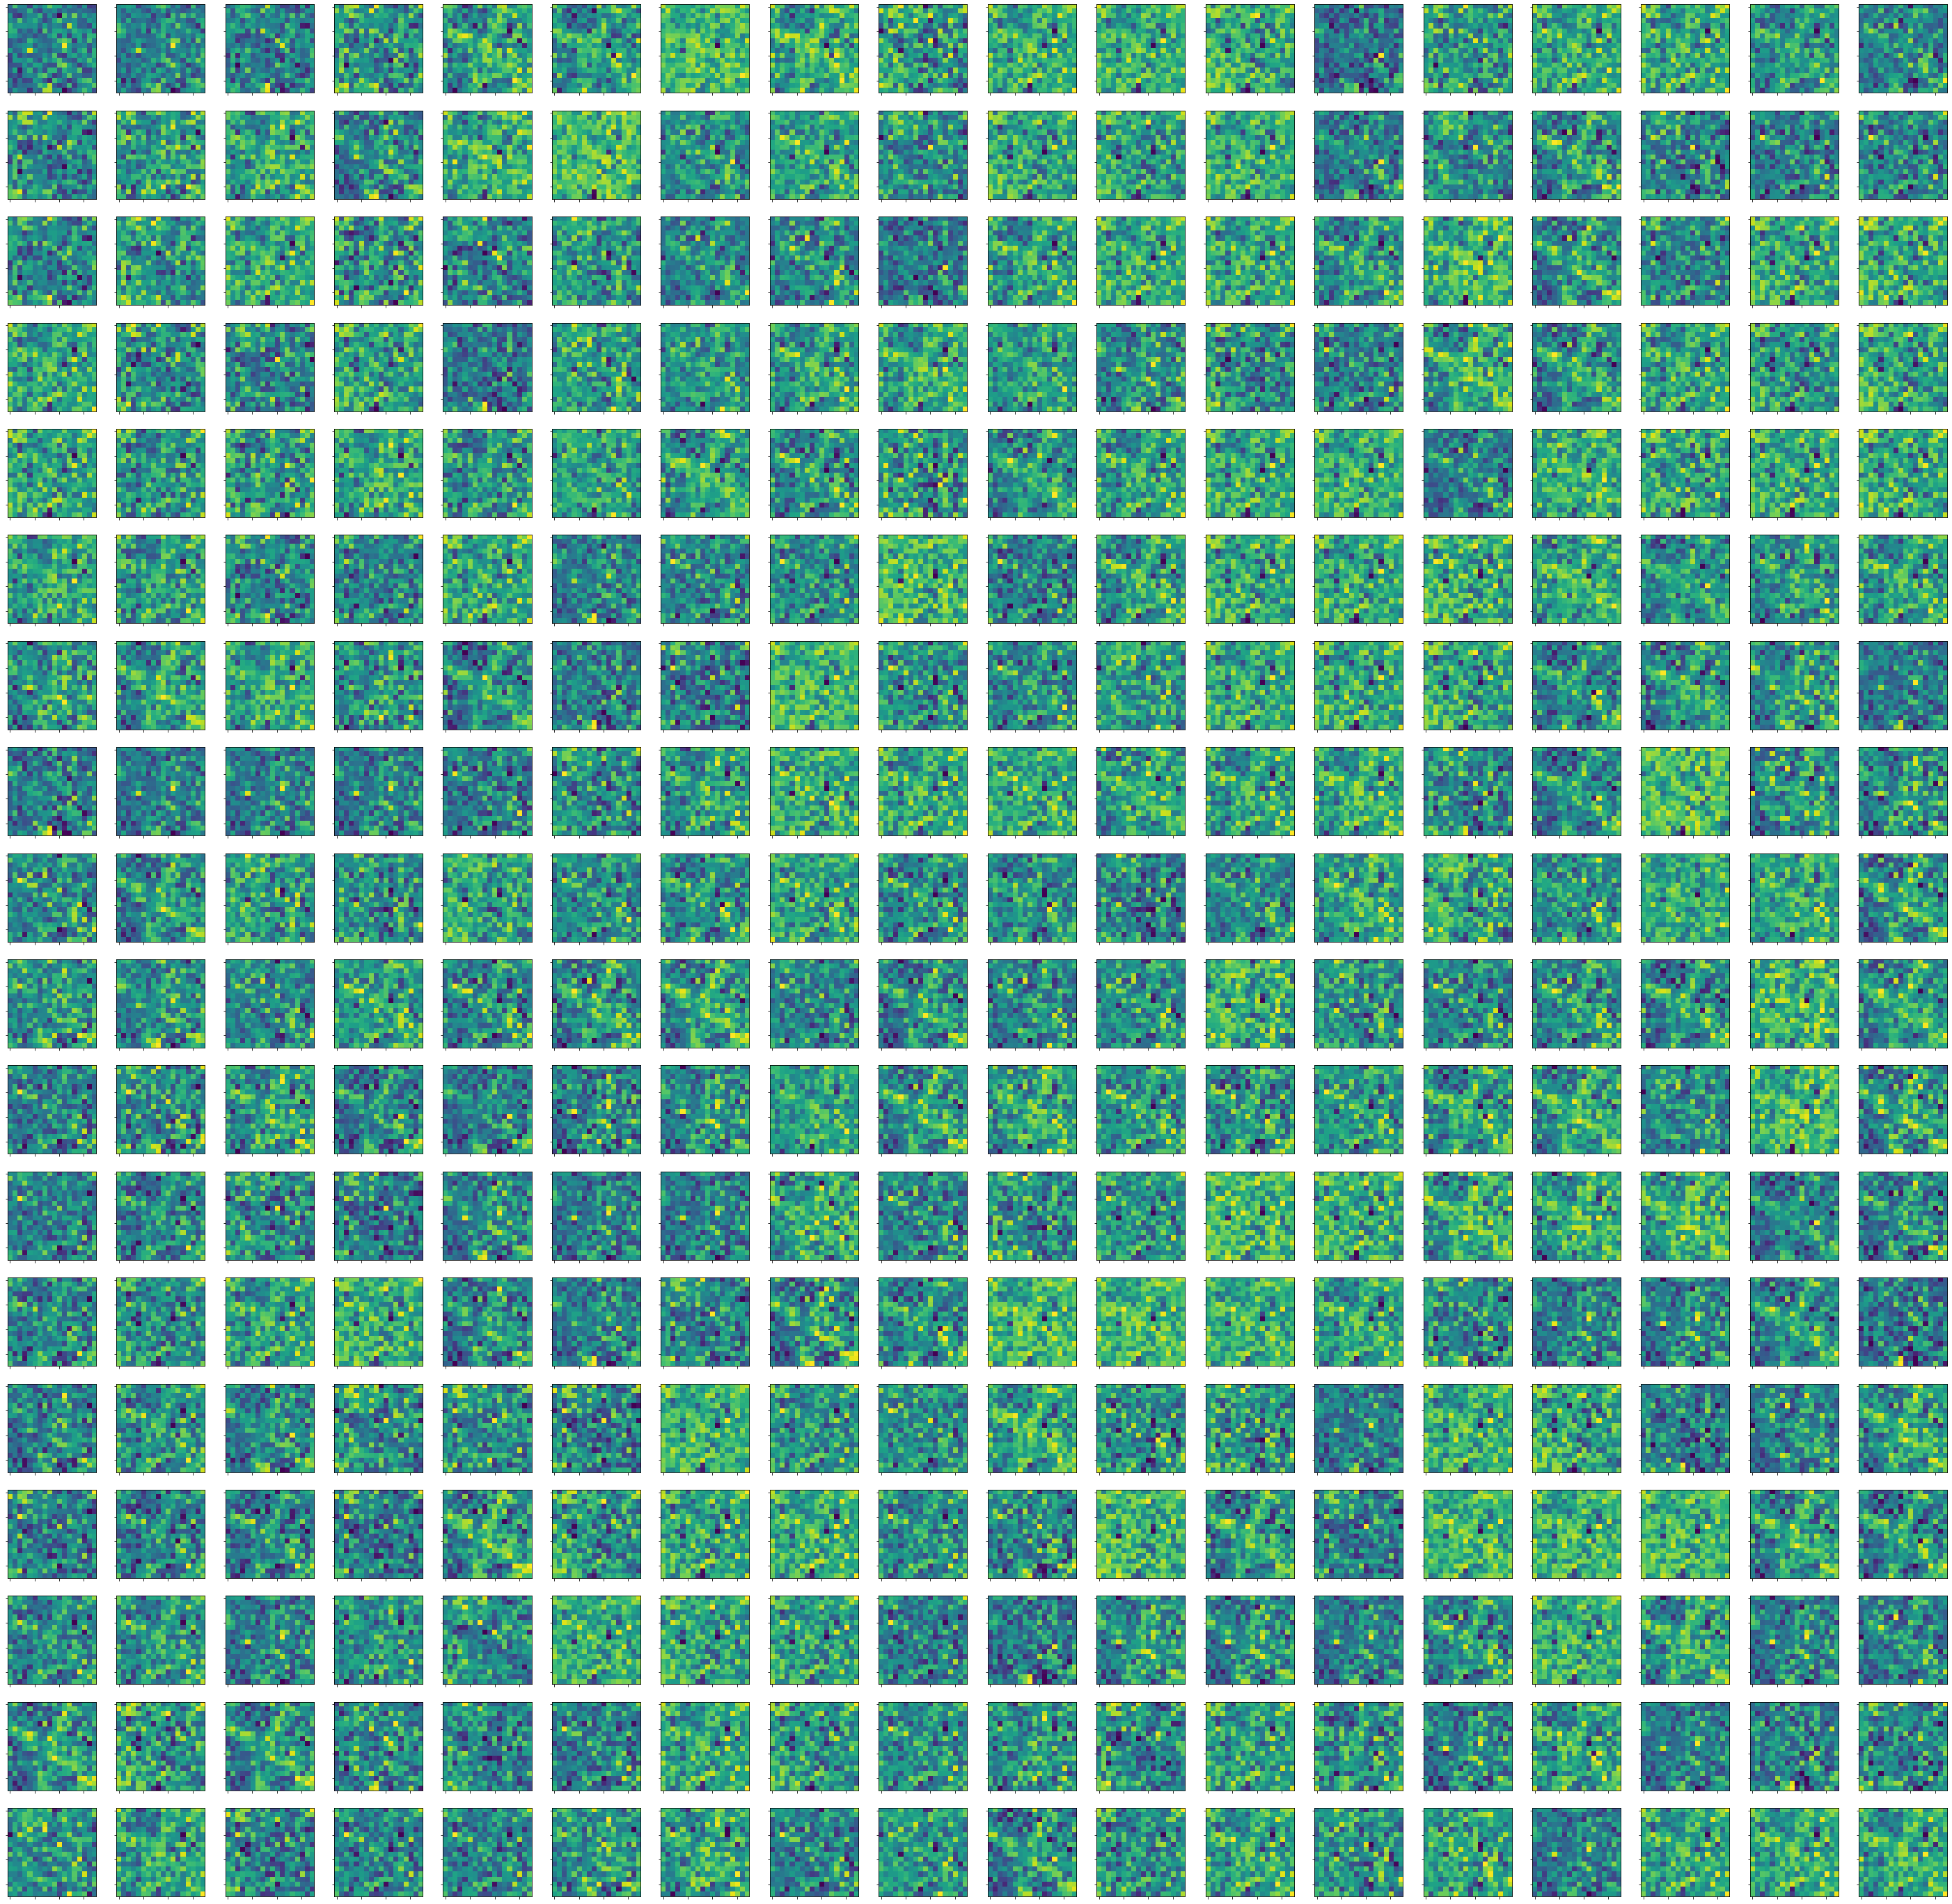

In [214]:
figure1 = plt.figure(figsize=(50, 50))
gs0 = gridspec.GridSpec(1, 1)
gs00 = gridspec.GridSpecFromSubplotSpec(18, 18, subplot_spec=gs0[0])
for i in range(18):
    for j in range(18):
        sim = similarity_matrix[i*18+j, :].detach().cpu()
        ax00 = figure1.add_subplot(gs00[i, j])
        ax00.imshow(sim.reshape(wl,wh))
        ax00.set_xticklabels([])
        ax00.set_yticklabels([])
        ax00.set_aspect('equal')
